In [156]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import time
import math

from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
from skimage.measure import shannon_entropy
from sklearn.metrics import silhouette_score
from skimage.measure import perimeter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew

from skimage import data, color
from skimage.segmentation import chan_vese
from skimage import img_as_float

# !pip install PyWavelets
# !pip install fuzzy-c-means

from sklearn.cluster import KMeans
from fcmeans import FCM

In [157]:
# run this only once!
# !pip uninstall -y opencv-contrib-python
# !pip install --no-cache-dir opencv-contrib-python

In [158]:
# For Google Colab:
# from google.colab import drive
# drive.mount('/content/drive')
trep_dir  = './ships-aerial-images/train_kepin/'

In [159]:
def Fetch_Images_Data(directory):
  trep_images   = []
  num = 0
  for path in os.listdir(directory):
    num = num + 1
    img = cv.imread(directory+path)
    if img is not None:
      trep_images.append(img)
  return trep_images

In [160]:
def conv_floatimage_to_uint8image(floatimage):
  floatimage = floatimage * 255
  floatimage = np.clip(floatimage, 0, 255)
  uint8image = floatimage.astype(np.uint8)
  return uint8image

def BGR_to_LAB(img):
  LAB_img = cv.cvtColor(img,cv.COLOR_BGR2LAB)
  return LAB_img

def LAB_to_BGR(img):
  BGR_img = cv.cvtColor(img,cv.COLOR_LAB2BGR)
  return BGR_img

def BGR_to_HSV(img):
  HSV_img = cv.cvtColor(img,cv.COLOR_BGR2HSV)
  return HSV_img

def HSV_to_BGR(img):
  BGR_img = cv.cvtColor(img,cv.COLOR_HSV2BGR)
  return BGR_img

def plot_comparison(original_image,segmented_image):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))
  plt.title("Original Image")
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(segmented_image, cmap='jet')
  plt.title("Sea-Land Segmentation")
  plt.axis('off')
  plt.show()
  return

In [161]:
def calculate_silhouette(flattened_image,labels):
  silhouette = silhouette_score(flattened_image, labels)
  return silhouette

def calculate_compactness(segmented_image, label_value):
    binary_mask = segmented_image == label_value
    area = np.sum(binary_mask)
    perim = perimeter(binary_mask)
    if area == 0:
        return np.inf
    return (perim ** 2) / area

In [162]:
def Median_Filtering(image,kernel_size):
  cleaned_img = cv.medianBlur(image,kernel_size)
  return cleaned_img

def Wavelet_Visushrink(img,threshold):
  sigma_est = estimate_sigma(img, channel_axis=-1, average_sigmas=True)
  im_visushrink = denoise_wavelet(
    img,
    channel_axis=-1,
    convert2ycbcr=True,
    method='VisuShrink',

    mode='soft',
    sigma=sigma_est/threshold,
    rescale_sigma=True,
  )
  cleaned_img = im_visushrink
  return cleaned_img

def CLAHE(channel):
  channel = np.uint8(channel)
  clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  res_channel = clahe.apply(channel)
  return res_channel

def Equalize_CLAHE_HSV(img):
  img = BGR_to_HSV(img)
  H, S, V = cv.split(img)
  new_V = CLAHE(V)
  new_img = cv.merge([H,S,new_V])
  new_img = HSV_to_BGR(new_img)
  return new_img

def LightEnhance_CIELAB(img,thresh):
  lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
  L, A, B = cv.split(lab)
  L_enhanced = cv.add(L, thresh)
  L_enhanced = np.clip(L_enhanced, 0, 255)
  lab_enhanced = cv.merge([L_enhanced, A, B])
  image_enhanced = cv.cvtColor(lab_enhanced, cv.COLOR_LAB2BGR)
  return image_enhanced

In [163]:
def Get_Superpixel_Segments(img, method):
    if method == "SLIC":
        LAB_img = BGR_to_LAB(img)
        slic = cv.ximgproc.createSuperpixelSLIC(LAB_img, algorithm=cv.ximgproc.SLIC, region_size=30, ruler=18.5)
        slic.iterate(10)
        segments = slic.getLabels()
    elif method == "SEEDS":
        LAB_img = BGR_to_LAB(img)
        num_superpixels = 800
        num_levels = 4
        width, height, channels = LAB_img.shape[1], LAB_img.shape[0], LAB_img.shape[2]
        seeds = cv.ximgproc.createSuperpixelSEEDS(width, height, channels, num_superpixels, num_levels)
        seeds.iterate(LAB_img, 160)
        segments = seeds.getLabels()
    elif method == "LSC":
        LAB_img = BGR_to_LAB(img)
        # print(LAB_img.dtype)
        lsc = cv.ximgproc.createSuperpixelLSC(LAB_img, region_size=30, ratio=0.065)
        lsc.iterate(10)
        segments = lsc.getLabels()
    else:
        raise ValueError("INVALID METHOD")
    return segments

def Compute_Superpixel_Features(features, segments):
    unique_segments = np.unique(segments)
    superpixel_features = []

    for seg in unique_segments:
        mask = (segments == seg)
        segment_features = features[mask.flatten()]
        mean_feature = segment_features.mean(axis=0)
        superpixel_features.append(mean_feature)

    return np.array(superpixel_features)

In [164]:
def Create_GaborFilters_Bank():
  filters = []

  ksize = 50
  sigma = 3
  theta = 1*np.pi/4
  lamda = 5
  gamma = 0.5
  phi = 0
  theta_list = [
    0.0 * theta, 0.25 * theta, 0.5 * theta, 0.75 * theta,
    1.0 * theta, 1.25 * theta, 1.5 * theta, 1.75 * theta,
    2.0 * theta, 2.25 * theta, 2.5 * theta, 2.75 * theta,
    3.0 * theta, 3.25 * theta, 3.5 * theta, 3.75 * theta
  ]
  lamda_list = [lamda*i for i in range(1, 17)]

  for thetas in theta_list:
    for lamdas in lamda_list:
      kernel = cv.getGaborKernel((ksize,ksize),sigma,thetas,lamdas,gamma,phi,ktype = cv.CV_32F)
      filters.append(kernel)
  return filters

def Apply_Gabor_Filters(image, filters):
    responses = []
    for kernel in filters:
        filtered = cv.filter2D(image, cv.CV_32F, kernel)
        responses.append(filtered)
    return responses

def combine_gabor_features(responses):
    feature_stack = np.stack(responses, axis=-1)
    feature_vector = feature_stack.reshape(-1, len(responses))
    return feature_vector

In [165]:
def Get_Preprocessed_Image(img):
  denoised_img = conv_floatimage_to_uint8image(Wavelet_Visushrink(img,1))
  contrast_img = Equalize_CLAHE_HSV(denoised_img)
  lightend_img = LightEnhance_CIELAB(contrast_img,-30)
  return lightend_img

def Get_Color_Features_1(img, method, segments):
  H, S, V = cv.split(cv.cvtColor(img, cv.COLOR_BGR2HSV))
  color_features = np.stack([H.flatten(), S.flatten()], axis=-1)
  scaler_color = StandardScaler()
  color_features_standardized = scaler_color.fit_transform(color_features)
  if method == "raw":
    return color_features_standardized
  elif method == "spx":
    superpixel_color_features = Compute_Superpixel_Features(color_features_standardized, segments.flatten())
    return superpixel_color_features
  else:
    raise ValueError("INVALID METHOD")

def Get_Color_Features_2(img, method, segments):
  L, A, B = cv.split(cv.cvtColor(img, cv.COLOR_BGR2LAB))
  color_features = np.stack([A.flatten(), B.flatten()], axis=-1)
  scaler_color = StandardScaler()
  color_features_standardized = scaler_color.fit_transform(color_features)
  if method == "raw":
    return color_features_standardized
  elif method == "spx":
    superpixel_color_features = Compute_Superpixel_Features(color_features_standardized, segments.flatten())
    return superpixel_color_features
  else:
    raise ValueError("INVALID METHOD")


def Get_Texture_Features(img, method, segments):
  H, S, V = cv.split(cv.cvtColor(img, cv.COLOR_BGR2HSV))
  GaborFilters_list = Create_GaborFilters_Bank()
  gab_resp = Apply_Gabor_Filters(V,GaborFilters_list)
  texture_features = combine_gabor_features(gab_resp)
  scaler_texture = StandardScaler()
  texture_features_standardized = scaler_texture.fit_transform(texture_features)
  if method == "raw":
    return texture_features_standardized
  elif method == "spx":
    superpixel_texture_features = Compute_Superpixel_Features(texture_features_standardized, segments.flatten())
    return superpixel_texture_features
  else:
    raise ValueError("INVALID METHOD")

def Get_Edge_Features(img,method,segments):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  edge_features = cv.Canny(gray, threshold1=200, threshold2=300, apertureSize=3, L2gradient=True)
  edge_features = edge_features.flatten()
  edge_features = edge_features.reshape(-1, 1)
  scaler_edge = StandardScaler()
  edge_features_standardized = scaler_edge.fit_transform(edge_features)
  if method == "raw":
    return edge_features_standardized
  elif method == "spx":
    superpixel_edge_features = Compute_Superpixel_Features(edge_features_standardized, segments.flatten())
    return superpixel_edge_features
  else:
    raise ValueError("INVALID METHOD")

def Get_Weighted_Features(feature1,feature2,feature3,feature4,fweight1,fweight2,fweight3,fweight4):
  weighted_features = np.hstack([
      feature1 * fweight1,
      feature2 * fweight2,
      feature3 * fweight3,
      feature4 * fweight4
  ])
  return weighted_features

In [166]:
images_list = Fetch_Images_Data(trep_dir)

#change here
img = images_list[25]

img = Get_Preprocessed_Image(img)

color_features_raw1 = Get_Color_Features_1(img,"raw",None)
color_features_raw2 = Get_Color_Features_2(img,"raw",None)
texture_features_raw = Get_Texture_Features(img,"raw",None)
edge_features = Get_Edge_Features(img,"raw",None)
weighted_features_raw = Get_Weighted_Features(color_features_raw1,color_features_raw2,texture_features_raw,edge_features,0.9,0.9,0.1,0.9)

In [167]:
segments = Get_Superpixel_Segments(img,"SEEDS")

color_features_spx1 = Get_Color_Features_1(img,"spx",segments)
color_features_spx2 = Get_Color_Features_2(img,"spx",segments)
texture_features_spx = Get_Texture_Features(img,"spx",segments)
edge_features = Get_Edge_Features(img,"spx",segments)
weighted_features_spx = Get_Weighted_Features(color_features_spx1,color_features_spx2,texture_features_spx,edge_features,0.9,0.9,0.1,0.9)

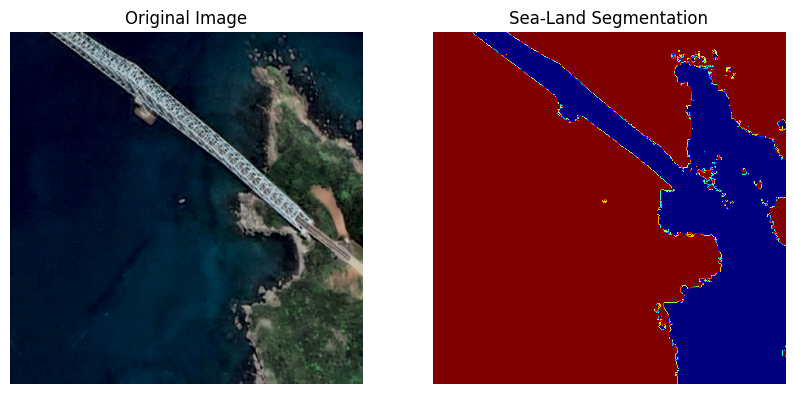

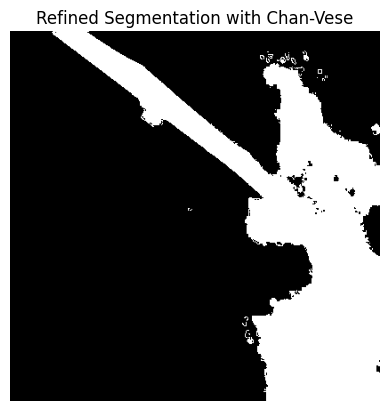

In [168]:
#kmeans
kmeans = KMeans(n_clusters=2, random_state = 42)
labels = kmeans.fit_predict(weighted_features_raw)
segmented_image = labels.reshape(img.shape[:2])

plot_comparison(img,segmented_image)
image_float = img_as_float(segmented_image)
segmentation_chanvese = chan_vese(image_float, mu=0.25, lambda1=1, lambda2=1, max_num_iter=200, tol=1e-3)
plt.imshow(segmentation_chanvese, cmap='gray')
plt.title("Refined Segmentation with Chan-Vese")
plt.axis('off')
plt.show()

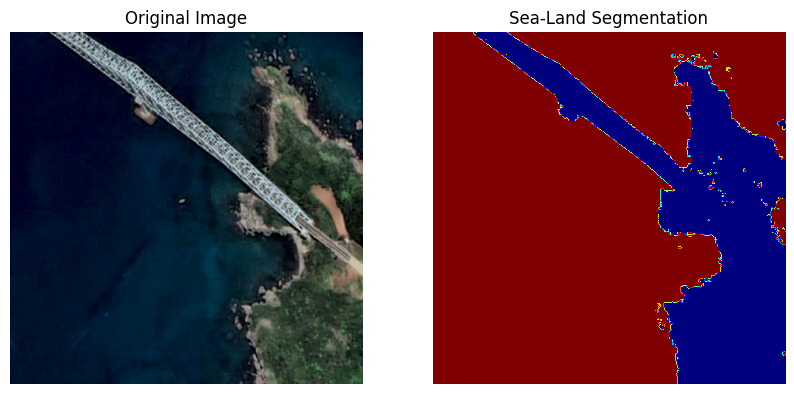

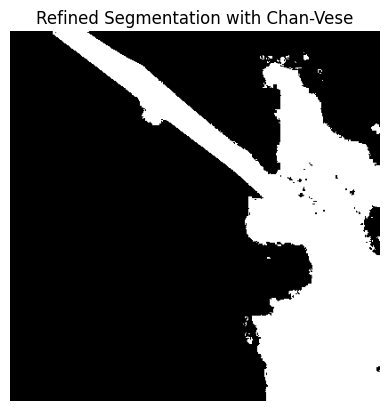

In [169]:
#Fuzzy C-means
fcm1 = FCM(n_clusters=2, random_state = 42, m = 2)
fcm1.fit(weighted_features_raw)
labels = fcm1.predict(weighted_features_raw)
segmented_image = labels.reshape(img.shape[:2])

plot_comparison(img,segmented_image)
image_float = img_as_float(segmented_image)
segmentation_chanvese = chan_vese(image_float, mu=0.25, lambda1=1, lambda2=1, max_num_iter=200, tol=1e-3)
plt.imshow(segmentation_chanvese, cmap='gray')
plt.title("Refined Segmentation with Chan-Vese")
plt.axis('off')
plt.show()

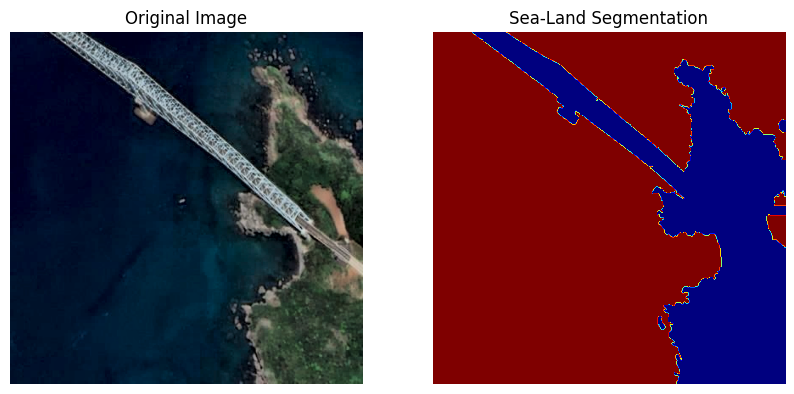

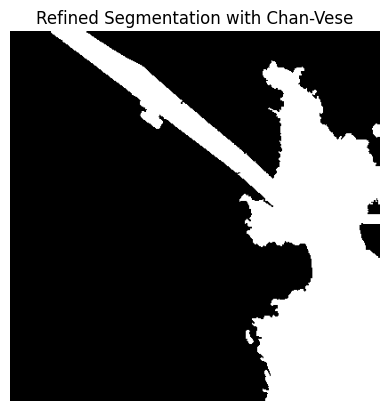

In [170]:
#fuzzt c-means with chan-vese model
fcm3 = FCM(n_clusters=2, random_state = 42, m = 2)
fcm3.fit(weighted_features_spx)
labels = fcm3.predict(weighted_features_spx)
superpixel_labels = fcm3.predict(weighted_features_spx)

segmented_image = np.zeros_like(segments)
for seg, label in zip(np.unique(segments), superpixel_labels):
    segmented_image[segments == seg] = label

plot_comparison(img,segmented_image)
image_float = img_as_float(segmented_image)
segmentation_chanvese = chan_vese(image_float, mu=0.25, lambda1=1, lambda2=1, max_num_iter=200, tol=1e-3)

plt.imshow(segmentation_chanvese, cmap='gray')
plt.title("Refined Segmentation with Chan-Vese")
plt.axis('off')
plt.show()

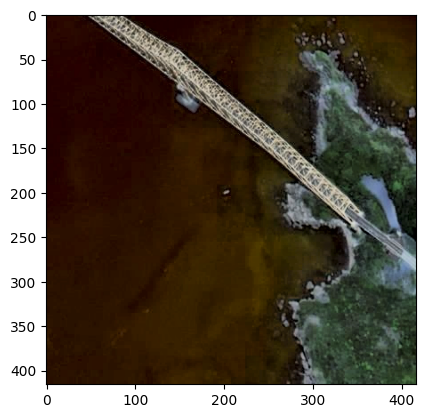

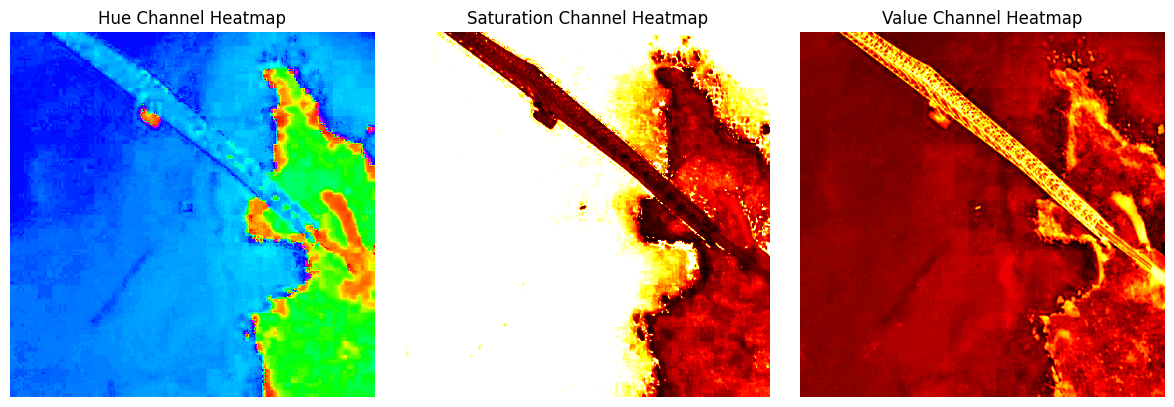

In [171]:
#buang
image = img
hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
hue, saturation, value = cv.split(hsv_image)

plt.imshow(image)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(hue, cmap='hsv')
plt.title('Hue Channel Heatmap')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(saturation, cmap='hot')
plt.title('Saturation Channel Heatmap')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(value, cmap='hot')
plt.title('Value Channel Heatmap')
plt.axis('off')
plt.tight_layout()
plt.show()